In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib nbagg
import numpy as np

In [2]:
import keras as K

Using TensorFlow backend.


In [3]:
import jams
import jams.display

In [4]:
import imp
import pumpp
import pickle

In [12]:
mod = imp.load_source('train_model', '/home/bmcfee/git/ismir2017_chords/code/train_model.py')

In [6]:
dmod = imp.load_source('train_deep', '/home/bmcfee/git/ismir2017_chords/code/train_deep.py')

In [7]:
with open('/home/bmcfee/git/ismir2017_chords/data/pump.pkl', 'rb') as fd:
    pump = pickle.load(fd)

/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MultiLabelBinarizer from version 0.18 when using version 0.18.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [16]:
cr1 = mod.construct_model(pump, False)[0]
cr1s = mod.construct_model(pump, True)[0]

In [8]:
cr2 = dmod.construct_model(pump, False)[0]
cr2s = dmod.construct_model(pump, True)[0]

In [17]:
cr1.load_weights('/home/bmcfee/git/ismir2017_chords/data/model_aug/fold04_weights.pkl')

In [18]:
cr1s.load_weights('/home/bmcfee/git/ismir2017_chords/data/model_struct_aug/fold04_weights.pkl')

In [9]:
cr2.load_weights('/home/bmcfee/git/ismir2017_chords/data/model_deep_aug/fold04_weights.pkl')

In [10]:
cr2s.load_weights('/home/bmcfee/git/ismir2017_chords/data/model_deep_struct_aug/fold04_weights.pkl')

In [26]:
L = cr1.layers[-2]

In [28]:
L = cr2.layers[-2]

In [30]:
L

In [31]:
L.output_shape

(None, None, 256)

In [20]:
cr1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cqt/mag (InputLayer)         (None, None, 216, 1)      0         
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 216, 1)      4         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, 216, 1)      26        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, None, 1, 36)       7812      
_________________________________________________________________
lambda_5 (Lambda)            (None, None, 36)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, None, 512)         450048    
_________________________________________________________________
chord_tag (TimeDistributed)  (None, None, 170)         87210     
Total para

In [19]:
cr2s.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cqt/mag (InputLayer)             (None, None, 216, 1)  0                                            
____________________________________________________________________________________________________
batch_normalization_2 (BatchNorm (None, None, 216, 1)  4                                            
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, None, 216, 1)  26                                           
____________________________________________________________________________________________________
conv2d_4 (Conv2D)                (None, None, 1, 36)   7812                                         
___________________________________________________________________________________________

In [13]:
vocab = pump['chord_tag'].vocabulary()

In [73]:
ivals, labs = [], []
for i, v in enumerate(vocab):
    ivals.append([float(i), i+0.95])
    labs.append(v)
ivals = np.asarray(ivals)

In [74]:
import mir_eval

In [75]:
y = mir_eval.sonify.chords(labs, ivals, 11025)

In [76]:
import soundfile

In [77]:
import jams

In [78]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

In [79]:
ann = jams.Annotation(namespace='chord')
for ival, lab in zip(ivals, labs):
    ann.append(time=ival[0], duration=ival[1]-ival[0], value=lab)
J = jams.JAMS(file_metadata=jams.FileMetadata(duration=float(np.max(ivals))))
J.annotations.append(ann)

In [80]:
soundfile.write('/home/bmcfee/git/chord_models/data/sweep.flac', y, 11025)

In [81]:
J.save('/home/bmcfee/git/chord_models/data/sweep.jams')

In [82]:
datum = pump.transform('/home/bmcfee/git/chord_models/data/sweep.flac',
                       '/home/bmcfee/git/chord_models/data/sweep.jams')

In [83]:
def get_annotated_embedding(model, pump, datum, layer=5):
    
    rnn = K.backend.function([model.get_layer('cqt/mag').input, K.backend.learning_phase()],
                             [model.layers[layer].output])
    
    embedding = rnn([datum['cqt/mag'], 0])[0][0]
    
    labels = pump['chord_tag'].encoder.inverse_transform(datum['chord_tag/chord'][0])[:, 0]
    
    n = min(len(labels), len(embedding))
    return embedding[:n], labels[:n]

In [84]:
def splitchord(label):
    
    if label in ('X', 'N'):
        return label, label
    
    else:
        return label.split(':', 2)

In [100]:
emb1a, lab1a = get_annotated_embedding(cr2, pump, datum, layer=5)

In [101]:
emb1b, lab1b = get_annotated_embedding(cr2, pump, datum, layer=6)

In [86]:
emb2a, lab2a = get_annotated_embedding(cr2s, pump, datum, layer=5)
emb2b, lab2b = get_annotated_embedding(cr2s, pump, datum, layer=6)

In [102]:
roots, quals = [], []
for l in lab1:
    r, q = splitchord(l)
    roots.append(r)
    quals.append(q)

In [103]:
e1a = TSNE(verbose=1).fit_transform(emb1a)
e1b = TSNE(verbose=1).fit_transform(emb1b)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1829
[t-SNE] Computed conditional probabilities for sample 1829 / 1829
[t-SNE] Mean sigma: 5.048100
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.881165
[t-SNE] Error after 350 iterations: 0.881165
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1829
[t-SNE] Computed conditional probabilities for sample 1829 / 1829
[t-SNE] Mean sigma: 5.422629
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.713543
[t-SNE] Error after 350 iterations: 0.713543


In [89]:
e2a = TSNE(verbose=1).fit_transform(emb2a)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1829
[t-SNE] Computed conditional probabilities for sample 1829 / 1829
[t-SNE] Mean sigma: 4.784146
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.841674
[t-SNE] Error after 325 iterations: 0.841674


In [90]:
e2b = TSNE(verbose=1).fit_transform(emb2b)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1829
[t-SNE] Computed conditional probabilities for sample 1829 / 1829
[t-SNE] Mean sigma: 5.226548
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.762065
[t-SNE] Error after 325 iterations: 0.762065


In [104]:
df1a = pd.DataFrame(data=e1a, columns=['x', 'y'])
df1a['label'] = lab1
df1a['root'] = roots
df1a['quality'] = quals

In [105]:
df1b = pd.DataFrame(data=e1b, columns=['x', 'y'])
df1b['label'] = lab1
df1b['root'] = roots
df1b['quality'] = quals

In [92]:
df2a = pd.DataFrame(data=e2a, columns=['x', 'y'])
df2a['label'] = lab1
df2a['root'] = roots
df2a['quality'] = quals

In [93]:
df2b = pd.DataFrame(data=e2b, columns=['x', 'y'])
df2b['label'] = lab1
df2b['root'] = roots
df2b['quality'] = quals

<IPython.core.display.Javascript object>


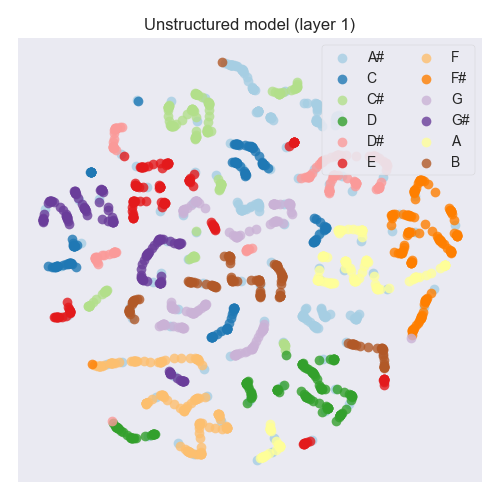

In [106]:
sns.lmplot('x', 'y', data=df1a.loc[~df1a['root'].isin(['X', 'N'])], fit_reg=False, hue='root', palette='Paired', legend=False, scatter_kws={'alpha': 0.8})
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.legend(frameon=True, framealpha=0.85, ncol=2, loc='best')
sns.despine(bottom=True, left=True)
plt.title("Unstructured model (layer 1)")
plt.tight_layout()

<IPython.core.display.Javascript object>


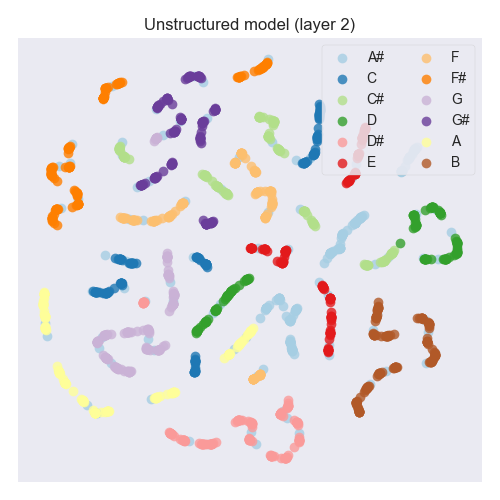

In [107]:
sns.lmplot('x', 'y', data=df1b.loc[~df1b['root'].isin(['X', 'N'])], fit_reg=False, hue='root', palette='Paired', legend=False, scatter_kws={'alpha': 0.8})
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.legend(frameon=True, framealpha=0.85, ncol=2, loc='best')
sns.despine(bottom=True, left=True)
plt.title("Unstructured model (layer 2)")
plt.tight_layout()

<IPython.core.display.Javascript object>


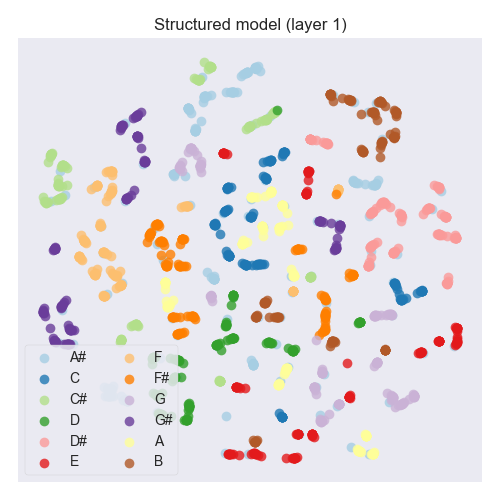

In [95]:
sns.lmplot('x', 'y', data=df2a.loc[~df2a['root'].isin(['X', 'N'])], fit_reg=False, hue='root', palette='Paired', legend=False, scatter_kws={'alpha': 0.8})
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.legend(frameon=True, framealpha=0.85, ncol=2, loc='best')
sns.despine(bottom=True, left=True)
plt.title("Structured model (layer 1)")
plt.tight_layout()

<IPython.core.display.Javascript object>


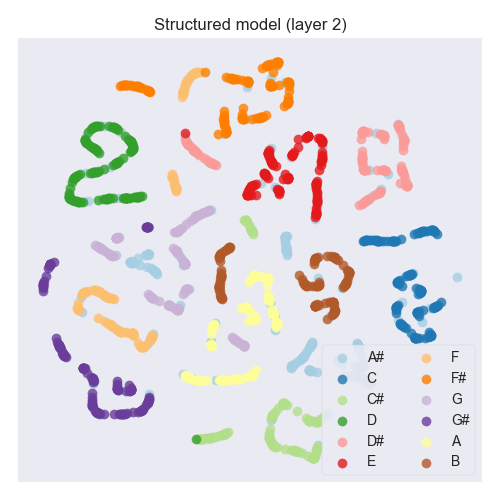

In [96]:
sns.lmplot('x', 'y', data=df2b.loc[~df2b['root'].isin(['X', 'N'])], fit_reg=False, hue='root', palette='Paired', legend=False, scatter_kws={'alpha': 0.8})
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.legend(frameon=True, framealpha=0.85, ncol=2, loc='best')
sns.despine(bottom=True, left=True)
plt.title("Structured model (layer 2)")
plt.tight_layout()

In [110]:
import librosa

In [118]:
semb1a = librosa.util.axis_sort(emb1a, axis=-1, value=np.var)
semb1b = librosa.util.axis_sort(emb1b, axis=-1, value=np.var)
semb2a = librosa.util.axis_sort(emb2a, axis=-1, value=np.var)
semb2b = librosa.util.axis_sort(emb2b, axis=-1, value=np.var)

In [121]:
semb1a.shape

(1829, 256)

In [120]:
datum['cqt/mag'].shape

(1, 1829, 216, 1)

<IPython.core.display.Javascript object>


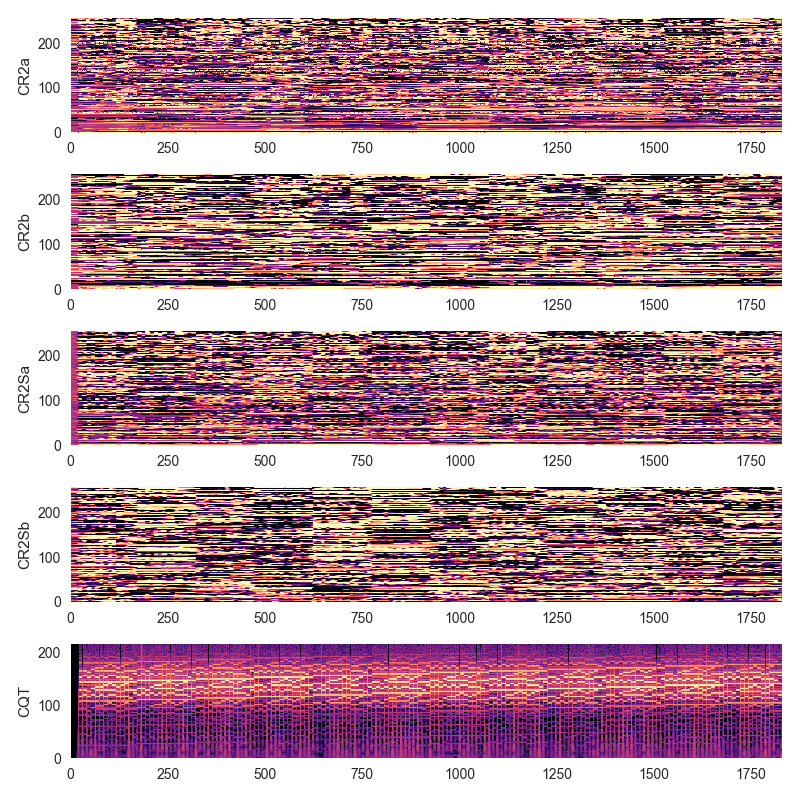

In [124]:
plt.figure(figsize=(8,8))
ax = plt.subplot(5,1,1)
plt.pcolormesh(semb1a.T, cmap='magma')
plt.ylabel('CR2a')

plt.subplot(5,1,2, sharex=ax)
plt.pcolormesh(semb1b.T, cmap='magma')
plt.ylabel('CR2b')

plt.subplot(5,1,3, sharex=ax)
plt.pcolormesh(semb2a.T, cmap='magma')
plt.ylabel('CR2Sa')

plt.subplot(5,1,4, sharex=ax)
plt.pcolormesh(semb2b.T, cmap='magma')
plt.ylabel('CR2Sb')

plt.subplot(5,1,5, sharex=ax)
plt.pcolormesh(datum['cqt/mag'].squeeze().T, cmap='magma')
plt.ylabel('CQT')

plt.tight_layout()